## Uncertainty Analysis

In [1]:
%%capture

!pip install tensorflow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import keras-cv for focal loss

!pip install keras-cv
import keras_cv

### Initial set-up for utilizing Colab GPU

In [2]:
# Set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Then initialize strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 1


### Data Loading

In [3]:
def preprocess(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return image, mask

# 1. Load saved test data
data = np.load("test_data.npz")
X_test_loaded, mask_test_loaded = data["X"], data["y"]

# 2. Rebuild tf.data.Dataset
test_data = tf.data.Dataset.from_tensor_slices((X_test_loaded, mask_test_loaded))

# 3. Apply same preprocessing pipeline
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# 4. Batch it
BATCH_SIZE = 8
test_data = test_data.batch(BATCH_SIZE)



### Verifying the loaded test data

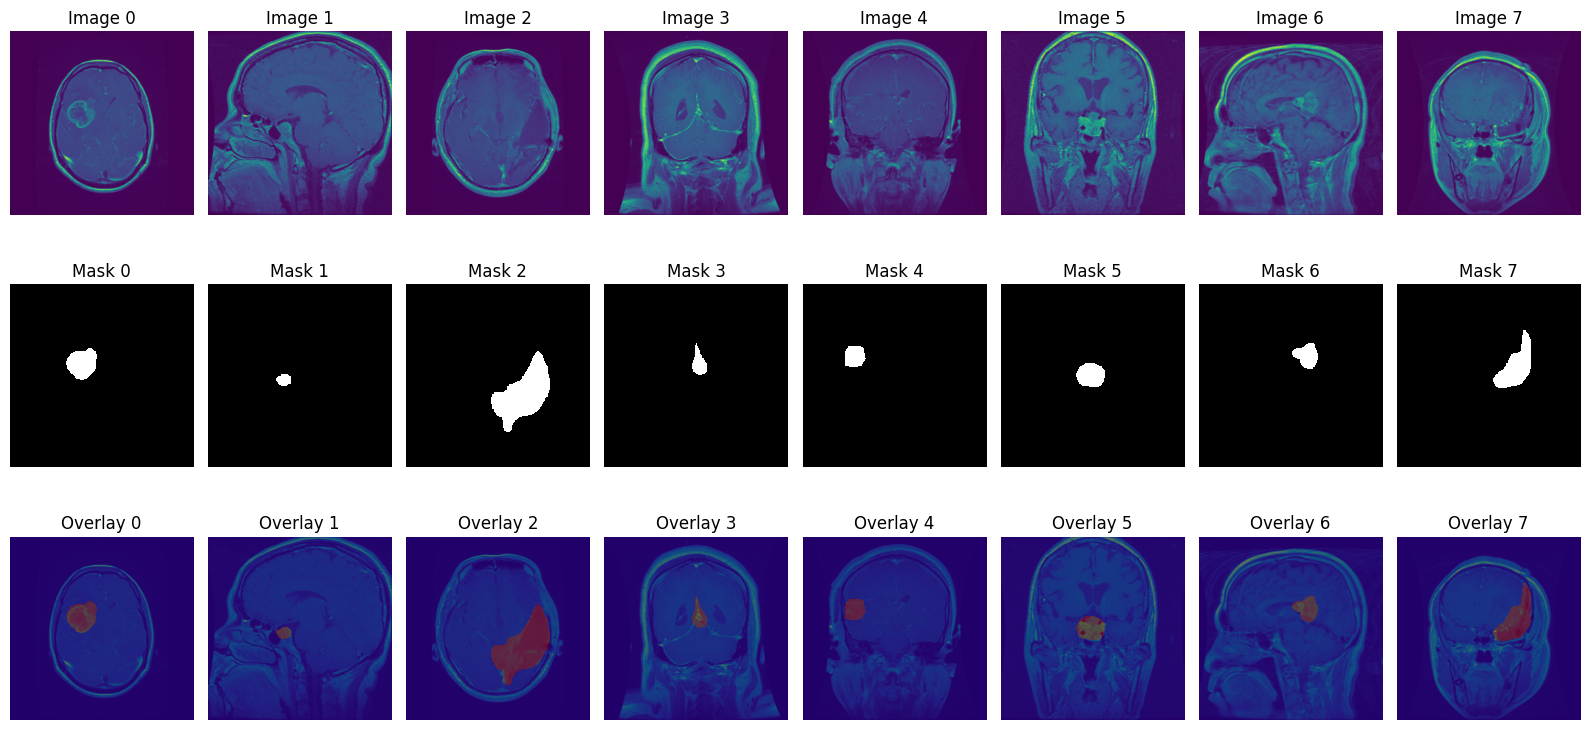

In [4]:
# Take one batch from the dataset
for images, masks in test_data.take(1):
    batch_size = images.shape[0]
    plt.figure(figsize=(16, 8))

    for i in range(batch_size):
        # Show image
        plt.subplot(3, batch_size, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i}")
        plt.axis('off')

        # Show corresponding mask
        plt.subplot(3, batch_size, batch_size + i + 1)
        plt.imshow((masks[i]), cmap='gray', interpolation="none")
        plt.title(f"Mask {i}")
        plt.axis('off')

         # Show the overlay of mask on the image
        plt.subplot(3, batch_size, 2 * batch_size + i + 1)
        plt.imshow(images[i])
        # Overlay the mask with transparency
        plt.imshow(masks[i], cmap='jet', alpha=0.5, interpolation="none")
        plt.title(f"Overlay {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
print("Test shapes:")
for img, mask in test_data.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)

Test shapes:
Image shape: (8, 256, 256, 1)
Mask shape: (8, 256, 256, 1)


In [6]:

for x, y in test_data.take(1):
    print("y min:", tf.reduce_min(y).numpy())
    print("y max:", tf.reduce_max(y).numpy())
    print("Unique values in y:", tf.unique(tf.reshape(y, [-1]))[0].numpy())

y min: 0.0
y max: 1.0
Unique values in y: [0. 1.]


In [7]:
for img, mask in test_data.take(1):
    print("Image dtype:", img.dtype, "Min:", tf.reduce_min(img).numpy(), "Max:", tf.reduce_max(img).numpy())
    print("Mask dtype:", mask.dtype, "Unique values:", tf.unique(tf.reshape(mask, [-1]))[0].numpy())

Image dtype: <dtype: 'float32'> Min: 0.0 Max: 0.9882353
Mask dtype: <dtype: 'float32'> Unique values: [0. 1.]


In [8]:
for img, mask in test_data:
    if img.shape[0] == 0 or tf.size(mask) == 0:
        print("Empty batch found")

In [9]:
total_pixels = 0
positive_pixels = 0

for _, mask in test_data.take(100):  # sample few batches
    total_pixels += tf.size(mask).numpy()
    positive_pixels += tf.reduce_sum(mask).numpy()

print("Positive pixels percentage:", (positive_pixels / total_pixels) * 100)

Positive pixels percentage: 1.7137337664406604


Convert the test data to numpy arrays for further study

In [10]:
# Get the image, mask data from test tensorflow dataset

# Initialize lists to store images and ground truth masks
all_images = []
all_masks = []

# Iterate through the dataset
for images, masks in test_data:
    all_images.append(images.numpy())  # Convert images to NumPy
    all_masks.append(masks.numpy())   # Convert masks to NumPy

# Flatten the lists to get all images and masks
all_images = np.concatenate(all_images, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

print(f'Total Images: {all_images.shape}')
print(f'Total Masks: {all_masks.shape}')

Total Images: (613, 256, 256, 1)
Total Masks: (613, 256, 256, 1)


### Loading model architecture

In [11]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_cv
from tensorflow.keras.metrics import BinaryIoU, Precision, Recall

In [12]:
%%capture
from unet import build_unet_model
model = build_unet_model()



In [13]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 34,512,193 (131.65 MB)

 Trainable params: 34,512,193 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

### Loading saved weights

In [15]:

model.load_weights('/content/weights_flip_1408.weights.h5')


### Uncertainty analysis using MC Dropout

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter

def mc_dropout_predictions(model, images, num_samples=50):
    predictions = []
    for _ in range(num_samples):
        preds = model(images, training=True)
        predictions.append(preds.numpy())
    predictions = np.array(predictions)

    mean_pred = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)


    return mean_pred, uncertainty


def analyze_entire_test_set(model, test_data, mc_samples=50):
    """
    Analyze the entire test set with MC dropout.
    Returns a list of results, one per image.
    """
    all_results = []
    img_counter = 0

    for batch_i, (images, masks) in enumerate(test_data):
        print(f"\nAnalyzing Batch {batch_i+1}...")

        # Run MC dropout on the whole batch
        mean_pred, uncertainty = mc_dropout_predictions(
            model, images, num_samples=mc_samples
        )

        # Store results per image in the batch
        for j in range(images.shape[0]):
            all_results.append({
                "image_index": img_counter,
                "image": images[j].numpy(),
                "mask": masks[j].numpy(),
                "mean_pred": mean_pred[j],
                "uncertainty": uncertainty[j]
            })
            img_counter += 1

    print(f"\n Analysis complete. Total images analyzed: {img_counter}")
    return all_results



In [17]:
results = analyze_entire_test_set(model, test_data, mc_samples=50)


Analyzing Batch 1...

Analyzing Batch 2...

Analyzing Batch 3...

Analyzing Batch 4...

Analyzing Batch 5...

Analyzing Batch 6...

Analyzing Batch 7...

Analyzing Batch 8...

Analyzing Batch 9...

Analyzing Batch 10...

Analyzing Batch 11...

Analyzing Batch 12...

Analyzing Batch 13...

Analyzing Batch 14...

Analyzing Batch 15...

Analyzing Batch 16...

Analyzing Batch 17...

Analyzing Batch 18...

Analyzing Batch 19...

Analyzing Batch 20...

Analyzing Batch 21...

Analyzing Batch 22...

Analyzing Batch 23...

Analyzing Batch 24...

Analyzing Batch 25...

Analyzing Batch 26...

Analyzing Batch 27...

Analyzing Batch 28...

Analyzing Batch 29...

Analyzing Batch 30...

Analyzing Batch 31...

Analyzing Batch 32...

Analyzing Batch 33...

Analyzing Batch 34...

Analyzing Batch 35...

Analyzing Batch 36...

Analyzing Batch 37...

Analyzing Batch 38...

Analyzing Batch 39...

Analyzing Batch 40...

Analyzing Batch 41...

Analyzing Batch 42...

Analyzing Batch 43...

Analyzing Batch 44.

In [18]:
# calculate uncertainty statistics along
# the predicted boundaries

def calculate_boundary_metrics(mean_pred_for_img, uncertainty):

    # Threshold prediction to get binary mask
    binary_pred = (mean_pred_for_img[..., 0] > 0.5).astype(np.uint8)

    # Create boundary mask using Laplacian filter
    boundary_kernel = np.array([[-1, -1, -1],
                                [-1,  8, -1],
                                [-1, -1, -1]])
    boundary_mask = ndimage.convolve(binary_pred, boundary_kernel) > 0

    # Extract uncertainty values at boundary pixels
    boundary_uncertainties = uncertainty[..., 0][boundary_mask]

    # If no boundary pixels are identified, set all metrics as 0
    if boundary_uncertainties.size == 0:
        metrics = {
            'mean_boundary_uncertainty': 0.0,
            'std_boundary_uncertainty': 0.0,
            'max_boundary_uncertainty': 0.0,
            'boundary_length': 0
        }

     # Normal case: Boundary pixels are detected
    else:
        metrics = {
            'mean_boundary_uncertainty': np.mean(boundary_uncertainties),
            'std_boundary_uncertainty': np.std(boundary_uncertainties),
            'max_boundary_uncertainty': np.max(boundary_uncertainties),
            'boundary_length': np.sum(boundary_mask)
        }

    return metrics, boundary_mask

In [19]:
# Store per-image metrics
all_boundary_metrics = []
all_total_uncertainties = []

for result in results:
    img_uncertainty = result["uncertainty"]
    img_pred = result["mean_pred"]

    # Overall (total) uncertainty
    total_uncertainty = np.mean(img_uncertainty)
    all_total_uncertainties.append(total_uncertainty)

    # Boundary uncertainty metrics
    metrics, boundary_mask = calculate_boundary_metrics(img_pred, img_uncertainty)
    all_boundary_metrics.append(metrics)

In [20]:
print("\n=== Dataset-Level Summary ===")
print(f"Average Total Uncertainty: {np.mean(all_total_uncertainties):.4f}")

print("\nAverage Boundary Metrics Across Test Data:")
for key in all_boundary_metrics[0].keys():
    avg = np.mean([m[key] for m in all_boundary_metrics])
    print(f"{key}: {avg:.4f}")


=== Dataset-Level Summary ===
Average Total Uncertainty: 0.0044

Average Boundary Metrics Across Test Data:
mean_boundary_uncertainty: 0.0382
std_boundary_uncertainty: 0.0101
max_boundary_uncertainty: 0.0656
boundary_length: 252.2773


Save metrics for each image

In [21]:
import pandas  as pd

# Merge total uncertainty into the boundary metrics before saving
for i, metrics in enumerate(all_boundary_metrics):
    metrics['total_uncertainty'] = all_total_uncertainties[i]

df = pd.DataFrame(all_boundary_metrics)
df.to_csv("uncertainty_metrics.csv", index=False)

Save overall results in a txt file

In [22]:
# Save results in the form of a file too

summary_file = "uncertainty_scale_1908.txt"

with open(summary_file, "w") as f:
    f.write("=== Dataset-Level Summary ===\n")
    f.write(f"Average Total Uncertainty: {np.mean(all_total_uncertainties):.4f}\n\n")

    f.write("Average Boundary Metrics Across Test Data:\n")
    for key in all_boundary_metrics[0].keys():
        avg = np.mean([m[key] for m in all_boundary_metrics])
        f.write(f"{key}: {avg:.4f}\n")

print(f"\nSummary saved to {summary_file}")



Summary saved to uncertainty_scale_1908.txt


Plot the visualization for few samples

In [23]:
def plot_uncertainty_distributions(uncertainty, boundary_uncertainty):
    """
    Plot distributions of different uncertainty measures.
    """
    plt.figure(figsize=(12, 4))

    # Overall uncertainty distribution
    plt.subplot(121)
    plt.title("Overall Uncertainty Distribution")
    plt.hist(uncertainty[..., 0].flatten(), bins=50, density=True, alpha=0.7)
    plt.xlabel("Uncertainty Value")
    plt.ylabel("Density")

    # Boundary uncertainty distribution
    plt.subplot(122)
    plt.title("Boundary Uncertainty Distribution")
    plt.hist(boundary_uncertainty[..., 0].flatten(), bins=50, density=True, alpha=0.7)
    plt.xlabel("Boundary Uncertainty Value")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.show()


def visualize_uncertainty(image, mean_pred, uncertainty, boundary_uncertainty, ground_truth=None, index=0):
    plt.figure(figsize=(20, 8))

    # Original layout
    plt.subplot(231)
    plt.title("Original Image")
    plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    plt.subplot(232)
    plt.title("Prediction Overlay")
    plt.imshow(image[..., 0], cmap='gray')
    prediction_mask = mean_pred[..., 0] > 0.5
    overlay = np.ma.masked_where(~prediction_mask, prediction_mask)
    plt.imshow(overlay, cmap='cool', alpha=0.6)
    plt.axis('off')

    plt.subplot(233)
    plt.title("Model Uncertainty")
    uncertainty_plot = plt.imshow(gaussian_filter(uncertainty[..., 0], sigma=1), cmap='hot')
    plt.colorbar(uncertainty_plot)
    plt.axis('off')

    plt.subplot(234)
    plt.title("Boundary Uncertainty")
    boundary_plot = plt.imshow(gaussian_filter(boundary_uncertainty[..., 0], sigma=1), cmap='viridis')
    plt.colorbar(boundary_plot)
    plt.axis('off')

    # Boundary probability map
    plt.subplot(235)
    plt.title("Boundary Probability")
    _, boundary_mask = calculate_boundary_metrics(mean_pred, uncertainty)
    plt.imshow(gaussian_filter(boundary_mask.astype(float), sigma=1), cmap='RdYlBu')
    plt.colorbar()
    plt.axis('off')

    # Ground truth comparison
    plt.subplot(236)
    if ground_truth is not None:
        plt.title("Ground Truth vs Prediction")
        plt.imshow(image[..., 0], cmap='gray')
        truth_mask = ground_truth[..., 0] > 0.5
        pred_mask = mean_pred[..., 0] > 0.5

        comparison = np.zeros((*truth_mask.shape, 3))
        comparison[truth_mask & pred_mask] = [0, 1, 0]  # True Positive
        comparison[~truth_mask & pred_mask] = [1, 0, 0]  # False Positive
        comparison[truth_mask & ~pred_mask] = [0, 0, 1]  # False Negative

        plt.imshow(comparison, alpha=0.6)
    else:
        plt.title("No Ground Truth Available")
        plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot uncertainty distributions
    plot_uncertainty_distributions(uncertainty, boundary_uncertainty)

    # Print metrics
    print(f"\nUncertainty Metrics for Image {index+1}:")
    boundary_metrics, _ = calculate_boundary_metrics(mean_pred, uncertainty)
    print(f"Mean Uncertainty: {np.mean(uncertainty):.4f}")
    print(f"Max Uncertainty: {np.max(uncertainty):.4f}")
    print("\nBoundary Metrics:")
    for key, value in boundary_metrics.items():
        print(f"{key}: {value:.4f}")

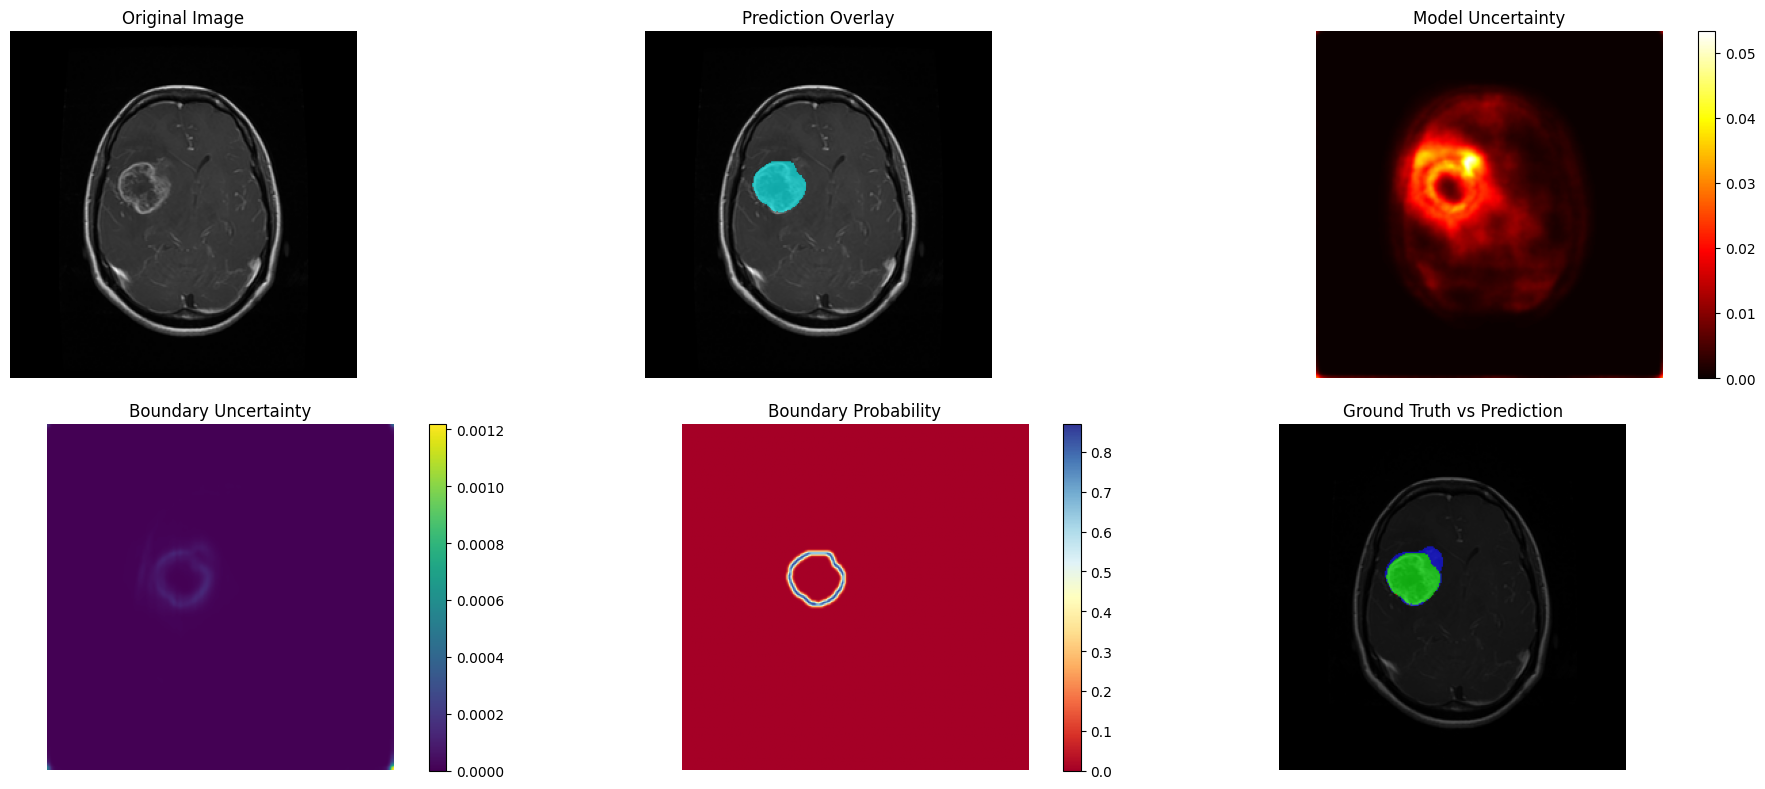

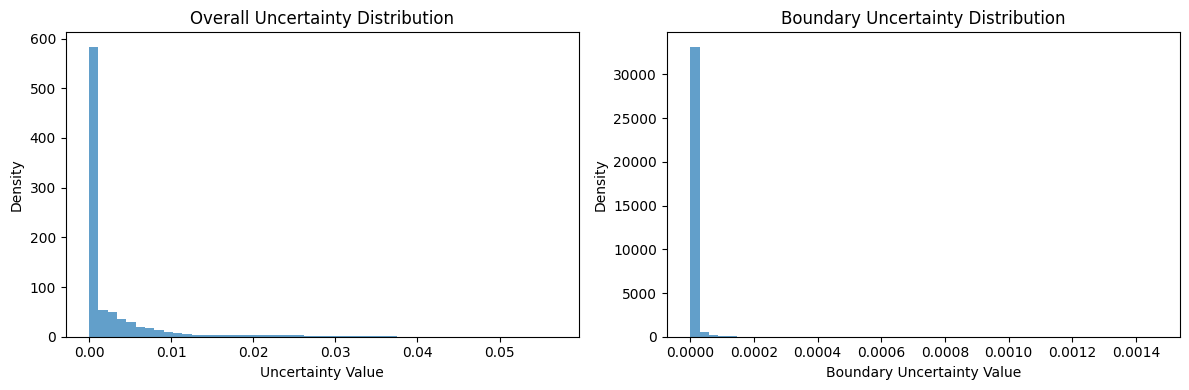


Uncertainty Metrics for Image 1:
Mean Uncertainty: 0.0027
Max Uncertainty: 0.0568

Boundary Metrics:
mean_boundary_uncertainty: 0.0281
std_boundary_uncertainty: 0.0080
max_boundary_uncertainty: 0.0568
boundary_length: 314.0000


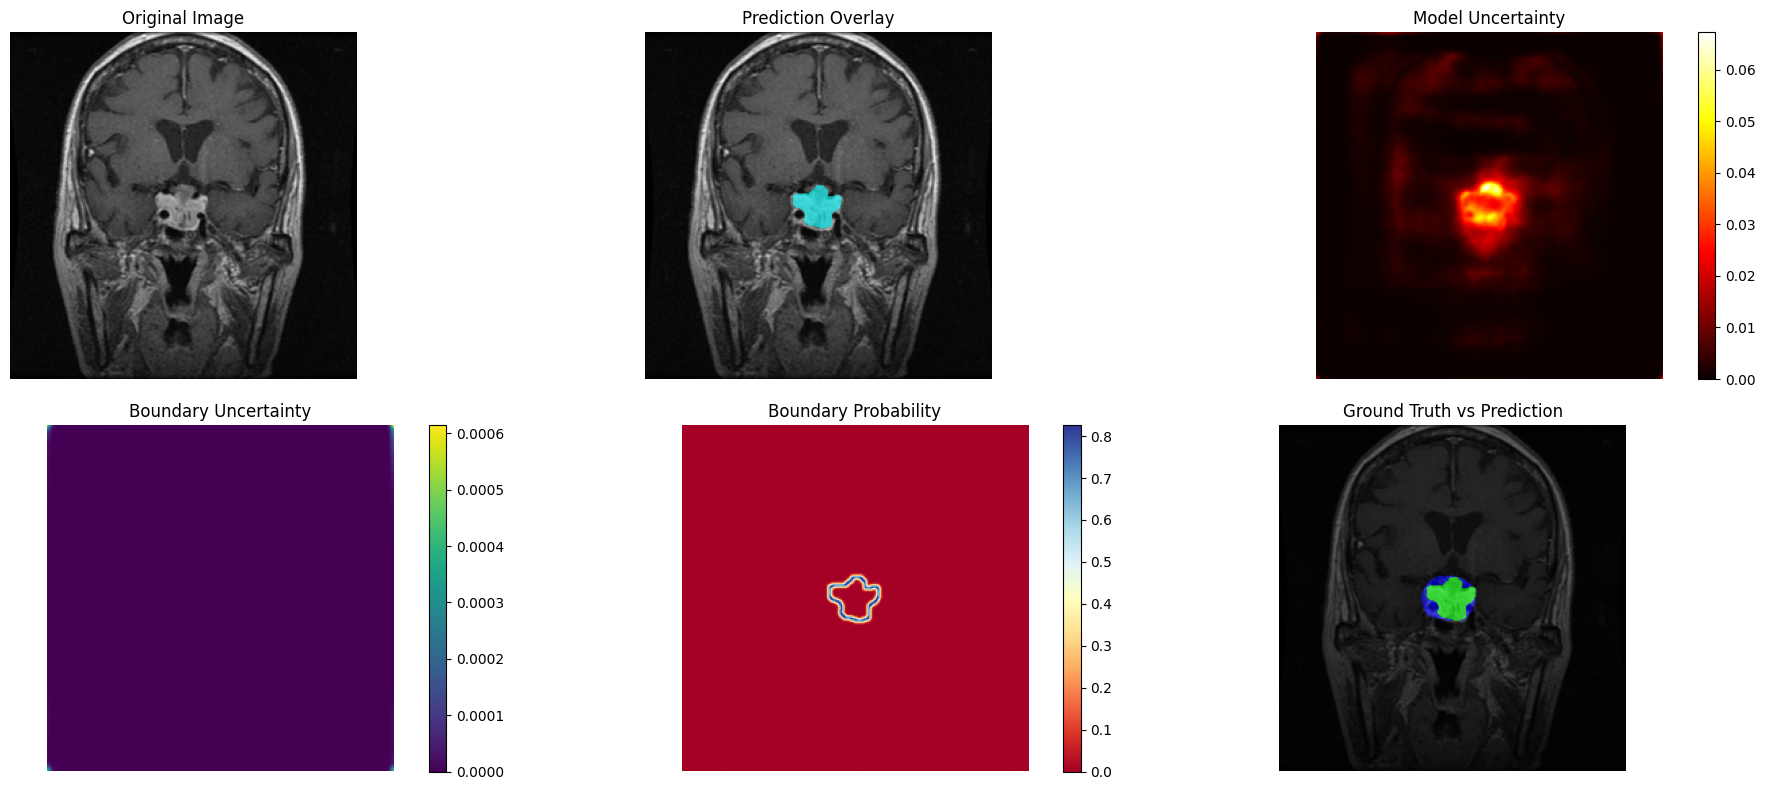

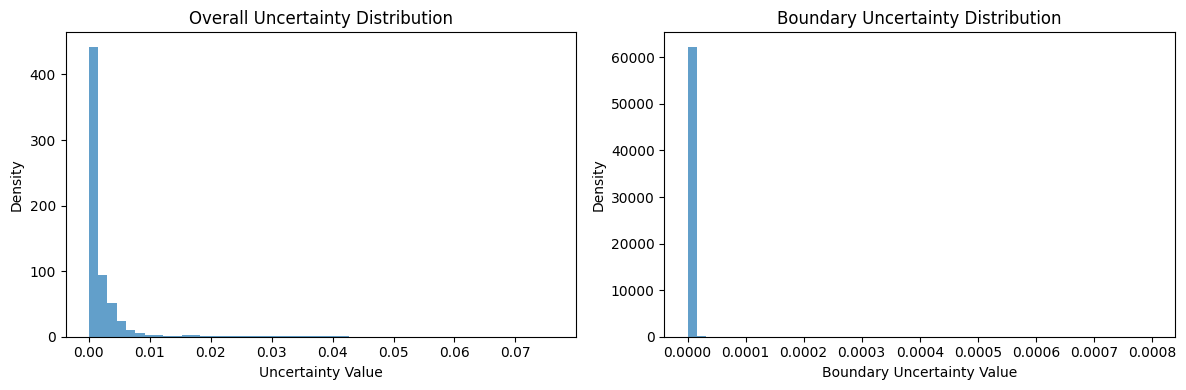


Uncertainty Metrics for Image 6:
Mean Uncertainty: 0.0022
Max Uncertainty: 0.0762

Boundary Metrics:
mean_boundary_uncertainty: 0.0391
std_boundary_uncertainty: 0.0124
max_boundary_uncertainty: 0.0762
boundary_length: 280.0000


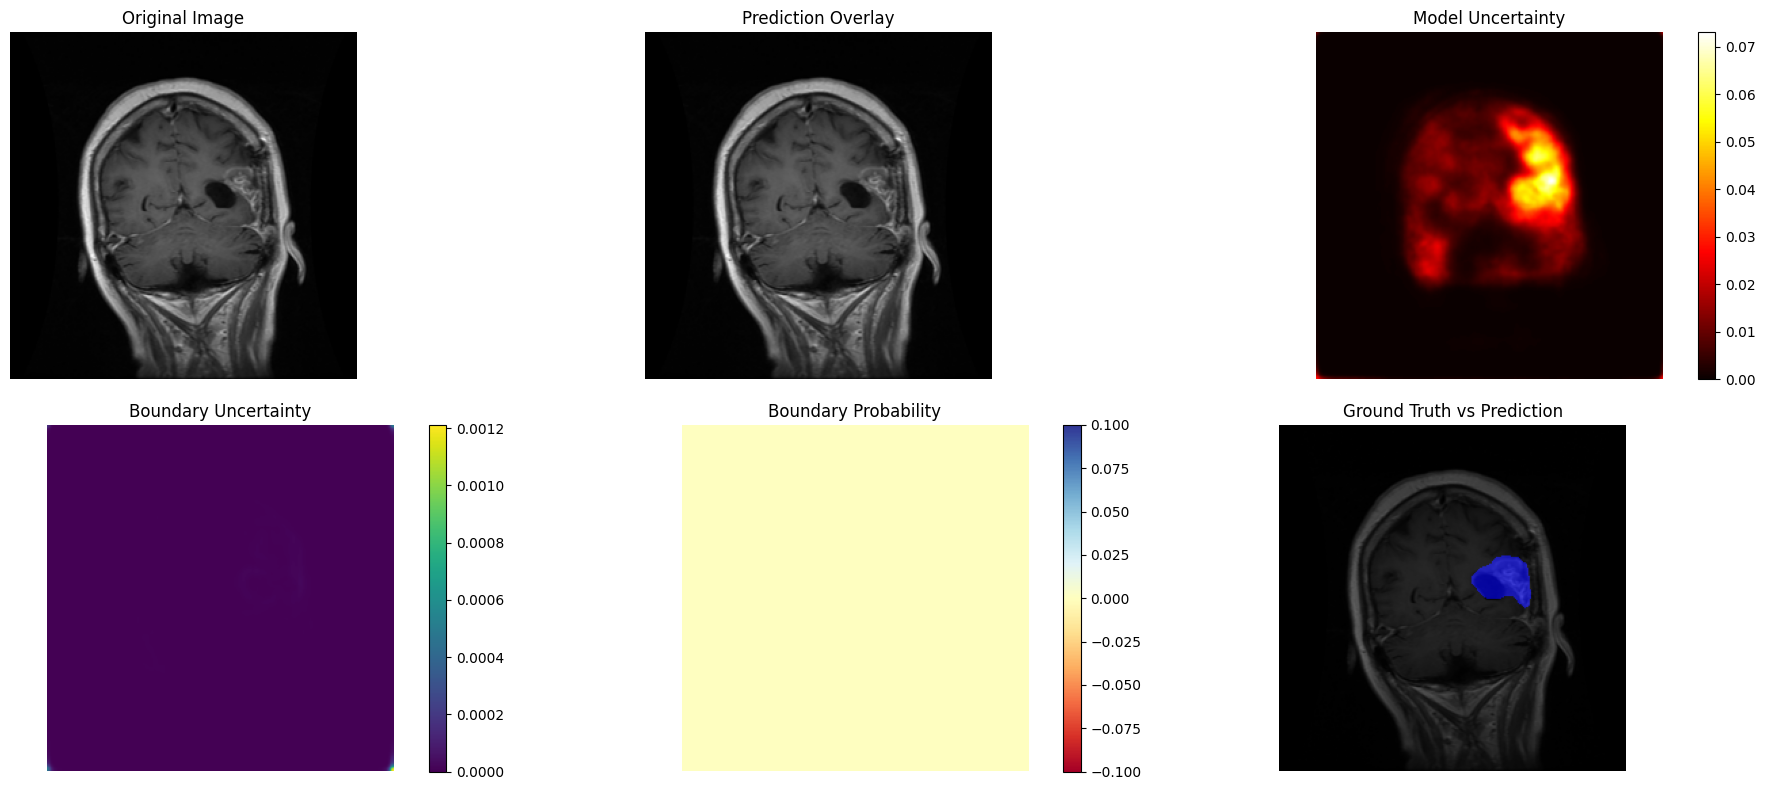

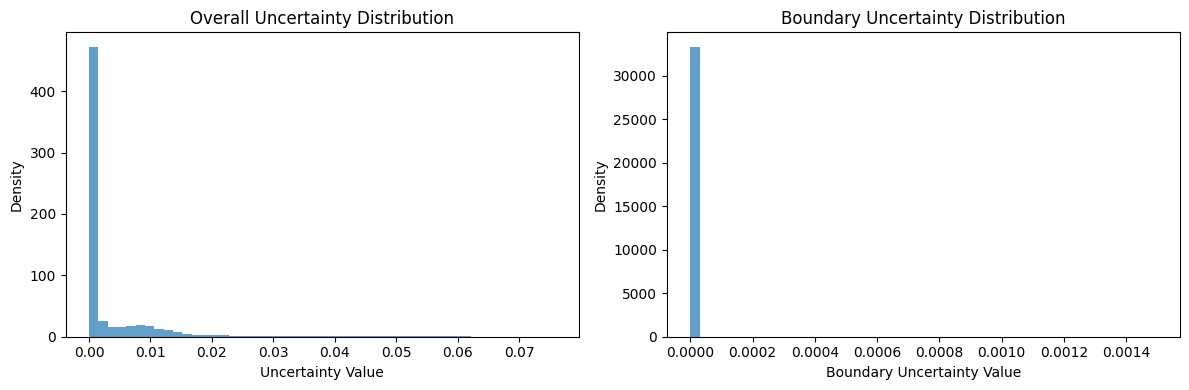


Uncertainty Metrics for Image 11:
Mean Uncertainty: 0.0038
Max Uncertainty: 0.0759

Boundary Metrics:
mean_boundary_uncertainty: 0.0000
std_boundary_uncertainty: 0.0000
max_boundary_uncertainty: 0.0000
boundary_length: 0.0000


In [24]:

sample_indices = [0, 5, 10]

for i in sample_indices:
    result = results[i]

    # Compute boundary uncertainty
    edges = ndimage.gaussian_gradient_magnitude(result["mean_pred"][..., 0], sigma=1)
    boundary_uncertainty = result["uncertainty"][..., 0] * edges[..., None]

    # Visualize
    visualize_uncertainty(
        image=result["image"],
        mean_pred=result["mean_pred"],
        uncertainty=result["uncertainty"],
        boundary_uncertainty=boundary_uncertainty,
        ground_truth=result["mask"],
        index=i
    )


### Correlating error and uncertainty metrics

In [25]:
# Compute error map

def get_error_map(mean_pred, ground_truth, threshold=0.5):
    """
    Calculate binary error map where prediction != ground truth.
    """
    # Binarize prediction
    binary_pred = (mean_pred[..., 0] > threshold).astype(np.uint8)
    binary_gt = ground_truth[..., 0].astype(np.uint8)

    # Error map: 1 where prediction != ground truth, else 0
    error_map = (binary_pred != binary_gt).astype(np.uint8)
    return error_map


In [26]:
# Get Pearson correlation between flattened maps

from scipy.stats import pearsonr

def compute_uncertainty_error_correlation(uncertainty_map, error_map):
    """
    Compute Pearson correlation coefficient between
    flattened uncertainty and error maps.
    """
    u_flat = uncertainty_map[..., 0].flatten()
    e_flat = error_map.flatten()

    # Check for zero variance to avoid compute errors
    if np.std(u_flat) == 0 or np.std(e_flat) == 0:
        return np.nan
    corr, _ = pearsonr(u_flat, e_flat)
    return corr


In [27]:
correlations = []

for result in results:
    mean_pred = result["mean_pred"]
    uncertainty = result["uncertainty"]
    ground_truth = result["mask"]

    # Get error map for this image
    error_map = get_error_map(mean_pred, ground_truth)

    # Compute Pearson correlation
    corr = compute_uncertainty_error_correlation(uncertainty, error_map)
    correlations.append(corr)

# Aggregate correlations over test images
mean_corr = np.nanmean(correlations)
print(f"\nMean uncertainty-error correlation over test set: {mean_corr:.4f}")



Mean uncertainty-error correlation over test set: 0.3014


In [28]:
def compute_boundary_uncertainty_error_correlation(uncertainty_map, error_map, boundary_mask):
    u_flat = uncertainty_map[..., 0][boundary_mask].flatten()
    e_flat = error_map[boundary_mask].flatten()
    if len(u_flat) == 0 or np.std(u_flat) == 0 or np.std(e_flat) == 0:
        return 0.0
    corr, _ = pearsonr(u_flat, e_flat)
    return corr

boundary_correlations = []

for result in results:
    mean_pred = result["mean_pred"]
    uncertainty = result["uncertainty"]
    ground_truth = result["mask"]

    error_map = get_error_map(mean_pred, ground_truth)
    _, boundary_mask = calculate_boundary_metrics(mean_pred, uncertainty)

    corr = compute_boundary_uncertainty_error_correlation(uncertainty, error_map, boundary_mask)
    boundary_correlations.append(corr)

mean_boundary_corr = np.mean(boundary_correlations)
print(f"\nMean boundary uncertainty-error correlation over test set: {mean_boundary_corr:.4f}")



Mean boundary uncertainty-error correlation over test set: 0.0369
